In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov
import csv
import glob
from scipy.stats import pearsonr,spearmanr

## 1. Ввод данных

In [152]:
# specifying the path to csv files
path = "DATA/"
# xlsx files in the path
file_list = glob.glob(path + "/*.xlsx")
print(file_list)

['DATA\\Daily Report 2-1-2021.xlsx', 'DATA\\Daily Report 2-10-2021.XLSX', 'DATA\\Daily Report 2-11-2021.XLSX', 'DATA\\Daily Report 2-12-2021.XLSX', 'DATA\\Daily Report 2-13-2021.XLSX', 'DATA\\Daily Report 2-14-2021.XLSX', 'DATA\\Daily Report 2-15-2021.XLSX', 'DATA\\Daily Report 2-16-2021.XLSX', 'DATA\\Daily Report 2-18-2021.XLSX', 'DATA\\Daily Report 2-19-2021.XLSX', 'DATA\\Daily Report 2-2-2021.xlsx', 'DATA\\Daily Report 2-20-2021.XLSX', 'DATA\\Daily Report 2-21-2021.XLSX', 'DATA\\Daily Report 2-22-2021.XLSX', 'DATA\\Daily Report 2-23-2021.XLSX', 'DATA\\Daily Report 2-24-2021.XLSX', 'DATA\\Daily Report 2-25-2021.XLSX', 'DATA\\Daily Report 2-26-2021.XLSX', 'DATA\\Daily Report 2-27-2021.XLSX', 'DATA\\Daily Report 2-28-2021.XLSX', 'DATA\\Daily Report 2-3-2021.XLSX', 'DATA\\Daily Report 2-4-2021.XLSX', 'DATA\\Daily Report 2-5-2021.XLSX', 'DATA\\Daily Report 2-6-2021.XLSX', 'DATA\\Daily Report 2-7-2021.XLSX', 'DATA\\Daily Report 2-8-2021.XLSX', 'DATA\\Daily Report 2-9-2021.XLSX', 'DATA\\Da

In [153]:
excl_list = []
for file in file_list:
    df = pd.read_excel(file, sheet_name='Daily', usecols="A:R", skiprows=0,nrows=5760, header = 0)
    df = pd.DataFrame(df) #преобразование в датафрейм
    df[["Date","Time"]]=df[["Date","Time"]].astype(str) #присвоение строкам типа "строка"
    df['timestamp']=pd.to_datetime(df.Date + ' ' + df.Time) #создание колонки с типом данных datetime
    df_changed=df #создание нового датафрейма
    df_changed.drop(['Date','Time'], inplace=True, axis=1) #убрать колонки Date and Time
    titles=list(df_changed.columns)
    titles[0],titles[16]=titles[16],titles[0] # смена порядка колонок
    df_changed=df_changed[titles]
    excl_list.append(df_changed)#добавляем новый элементв в конец
excl_merged = pd.concat(excl_list, axis=0, ignore_index=False) #конкатенация всех листов
excl_merged.head(4)

,timestamp,Hydraulic BAR Pressure bar,Current Curve Selected,Bowl Speed RPM RPM,Differential Speed RPM,Sludge Flow m3h,Centrifuge Vibration mm/sec,Solids End Bearing Temp Â°C,Liquid End Bearing Temp Â°C,SCI Scale Weight,SCI Scale Totalizer,Diverter Open %,Lube Flow Solid End,Lube Flow Liquid A,Lube Flow Liquid B,Hydraulic Temp,Bowl Speed %
0,2021-02-01 00:00:00,78.531898,1,1711,11.932508,86.082176,1.867694,76.106628,82.533424,9.548612,51010,100.0,91.634109,100.025322,92.494934,52.535667,69
1,2021-02-01 00:00:15,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72
2,2021-02-01 00:00:30,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72
3,2021-02-01 00:00:45,79.038269,1,1740,11.949870,363.299347,2.782335,76.118706,82.551537,7.327474,51010,100.0,90.917969,100.025322,92.661316,52.535667,70


In [154]:
excl_merged.to_excel('DATA_EXPORT/Total.xlsx', index = False)   

## 2. Анализ массива данных

In [ ]:
excl_merged.plot(figsize=(18, 5));

['DATA\\Daily Report 2-1-2021.xlsx', 'DATA\\Daily Report 2-2-2021.xlsx']


In [7]:
# list of excel files we want to merge.
# pd.read_excel(file_path) reads the excel
# data into pandas dataframe.

In [24]:
excl_list = []
i=0
for file in file_list:
    df=pd.read_excel(file, sheet_name='Daily', usecols="A:R", skiprows=0,nrows=5760, header = 0)
    df.to_excel('DATA_CHANGED/' + str(i)+'.xlsx',header=True, index = False)
    i=i+1
    print(i)

1
2


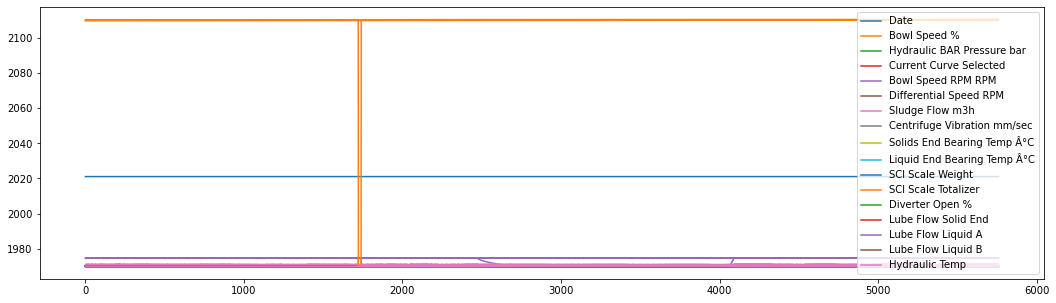

In [18]:
excl_merged.plot(figsize=(18, 5));

## Расчет корреляции двух рядов данных

In [2]:
#Расчет корреляции двух рядов данных
Indicators = {'System type': ['SS','PS','CL','IP','IR','DR'], 'R, bit/s': [133.405, 162.922,786.134,1146.229,444.442,1740.166],
        'MTBF (year)': [37,441,438,448,51,27917],
                }
df = pd.DataFrame(Indicators, columns = ['System type', 'R, bit/s','MTBF (year)'])

print (df)

  System type  R, bit/s  MTBF (year)
0          SS   133.405           37
1          PS   162.922          441
2          CL   786.134          438
3          IP  1146.229          448
4          IR   444.442           51
5          DR  1740.166        27917


In [3]:
R=df.iloc[:,1],
MTBF=df.iloc[:,2]
print (MTBF)

0       37
1      441
2      438
3      448
4       51
5    27917
Name: MTBF (year), dtype: int64


In [6]:
# calculate Pearson's correlation
covariance = cov(R, MTBF)
corr, _ = pearsonr(df.iloc[:,1], df.iloc[:,2])
corr1, _ = spearmanr(df.iloc[:,1], df.iloc[:,2])
print(covariance, 'Pearsons correlation: %.3f' % corr, 'Spearmans correlation: %.3f' % corr1)

[[3.91138917e+05 5.59247196e+06]
 [5.59247196e+06 1.27311103e+08]] Pearsons correlation: 0.793 Spearmans correlation: 0.829
